# Imports

## Basic Stuff

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import ast
import shap
import pickle
import os
import math

C:\Users\carlo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## sklearn

In [2]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, make_scorer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.inspection import permutation_importance

## Models

In [3]:
from catboost import CatBoostClassifier, Pool
import lightgbm as lgb
from xgboost import XGBClassifier
from bayes_opt import BayesianOptimization

# Load CSVs

In [4]:
control_df = pd.read_csv("../Dataset/train_radiomics_occipital_CONTROL.csv")
train_df = pd.read_csv("../Dataset/train_radiomics_hipocamp.csv")
test_df = pd.read_csv("../Dataset/test_radiomics_hipocamp.csv")
dummy_df = pd.read_csv("../Dataset/dummy_submission.csv")

# Data Exploration

## Category Encoder and Decoder

In [5]:
def target_encoder(df, target="Transition"):
    le_make = LabelEncoder()
    df[f"{target}_code"] = le_make.fit_transform(df[target])
    return le_make

def target_decoder(le_make, preds):
    return le_make.inverse_transform(preds)


In [6]:
le_make_train = target_encoder(train_df)
le_make_control = target_encoder(control_df)

Transition_code
1    0.314754
4    0.232787
3    0.222951
0    0.196721
2    0.032787
Name: proportion, dtype: float64

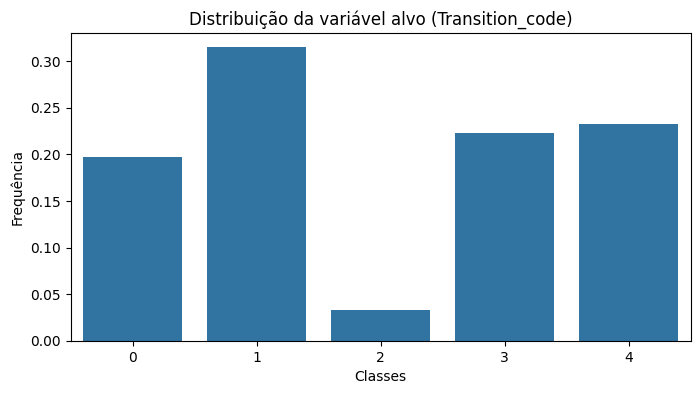

In [7]:
target_distribution = train_df['Transition_code'].value_counts(normalize=True)

plt.figure(figsize=(8, 4))
sns.barplot(x=target_distribution.index, y=target_distribution.values)
plt.title("Distribuição da variável alvo (Transition_code)")
plt.xlabel("Classes")
plt.ylabel("Frequência")

target_distribution

## MatPlots

In [8]:
def show_histogram(df,title="histogram"):
    plt.figure(figsize=(13,8))
    plt.subplots_adjust(bottom=0.17)
    plt.title(title)
    sns.histplot(df)
    plt.show()

In [9]:
def show_pie(df,title="pie"):
    labels = df.unique().tolist()
    counts = df.value_counts()
    sizes = [counts[var_cat] for var_cat in labels]
    _, ax1 = plt.subplots()
    ax1.pie(sizes, labels=labels, autopct="%1.1f%%",shadow=True)
    ax1.axis("equal")
    plt.title(title)
    plt.show()

In [10]:
def show_boxplot(df,title="boxplot"):
    plt.figure(figsize=(13,8))
    plt.subplots_adjust(bottom=0.17)
    df.boxplot()
    plt.xticks(rotation=15)
    plt.title(title)
    plt.show()


In [11]:
def show_heatmap(df,title="correlation heatmap"):
    df = df.select_dtypes(include="number")
    plt.figure(figsize=(13,8))
    plt.subplots_adjust(bottom=0.25,left=0.22,right=0.95)
    plt.xticks(rotation=15)
    plt.title(title)
    sns.heatmap(df.corr(),annot=True,cmap="coolwarm",linewidths=0.5)
    plt.show()

In [12]:
def show_jointplot(df,x_label,y_label,title="jointplot",hue="Transition_code"):
    sns.jointplot(data=df,x=x_label,y=y_label,hue=hue)
    plt.show()

In [13]:
def show_catplot(df, x_label, y_label, title="catplot", hue="Transition_code"):
    sns.catplot(data=df, x=x_label, y=y_label, hue=hue)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

In [14]:
def show_pairplot(df,hue="Transition_code"):
    sns.pairplot(df,hue=hue)
    plt.show()

## Basic Exploration

In [15]:
def main_exploration(df):
    print(df.shape) 

In [16]:
def numerical_exploration(df):
    # age exploration
    show_histogram(df["Age"],title="Histogram")
    print(df["Age"].describe())

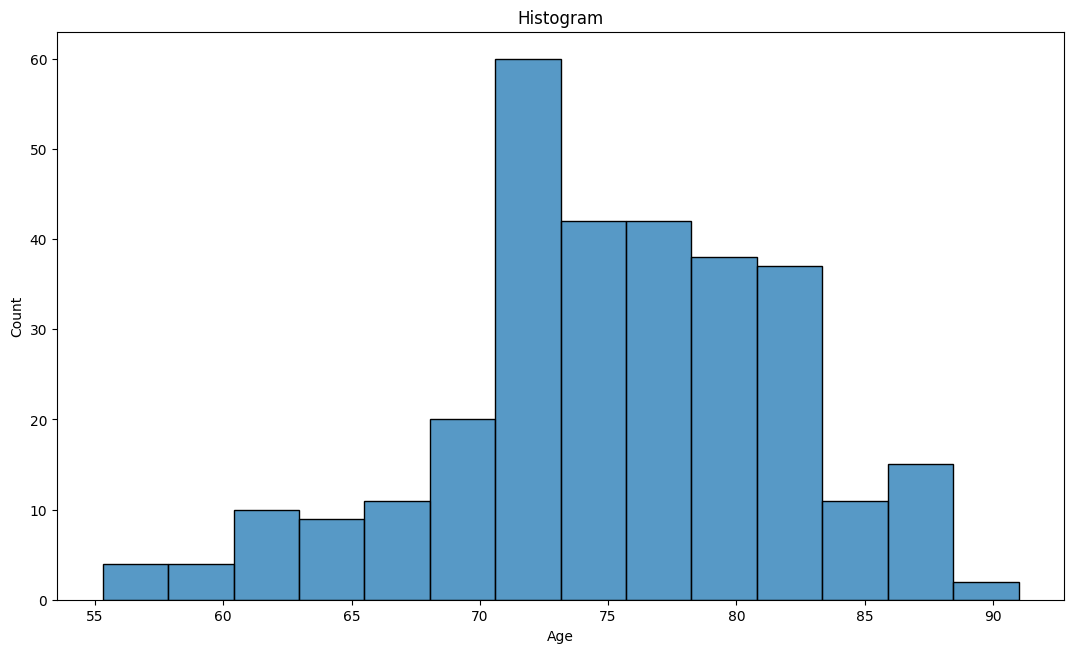

count    305.000000
mean      75.171148
std        6.675866
min       55.300000
25%       71.300000
50%       75.000000
75%       79.900000
max       91.000000
Name: Age, dtype: float64


In [17]:
numerical_exploration(train_df)

In [18]:
def categorical_exploration(df):
    """
    Transition description:
    CN - Cognitive Normal, estado normal
    MCI - Mild Cognitive Impairment, estado entre o avanço normal da perda de memoria com a idade e um certo declinio serio de demencia
    AD - Azlheimer Disease, forma mais comum de demencia nas pessoas mais velhas
    """
    categorical_df = df[["Sex","Transition"]]

    for column in categorical_df.columns:
        show_histogram(categorical_df[column],title=f"{column} histogram")
        print(df[column].value_counts())

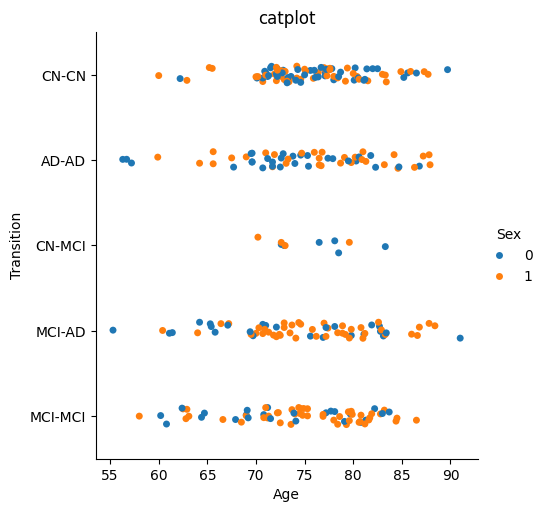

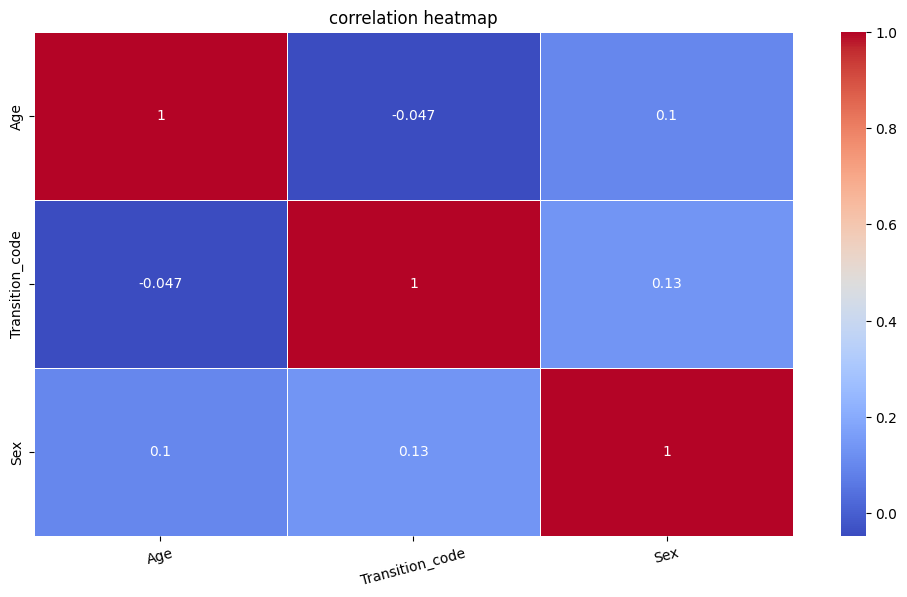

In [19]:
show_catplot(train_df, "Age", "Transition", hue="Sex")
show_heatmap(train_df[["Age","Transition_code","Sex"]])

<Axes: >

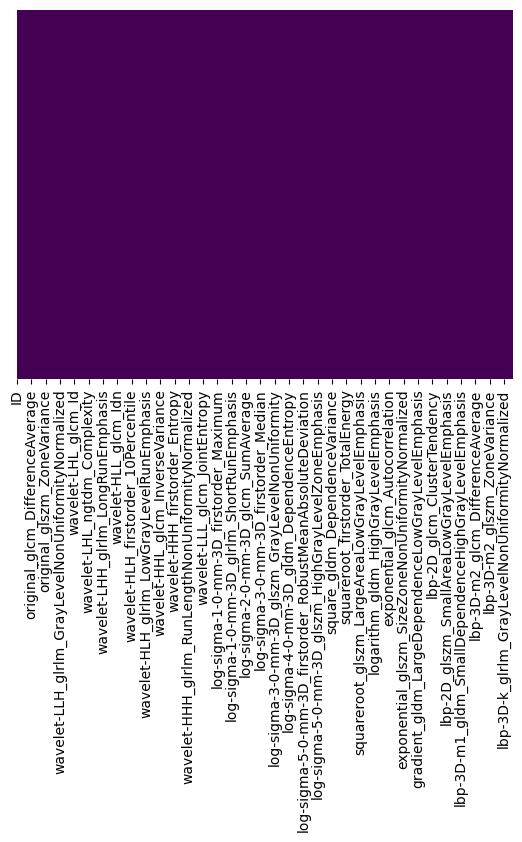

In [20]:
sns.heatmap(train_df.isnull(), yticklabels=False, cbar=False, cmap="viridis")

In [21]:
diagnostics_configs_columns = ["diagnostics_Configuration_Settings","diagnostics_Configuration_EnabledImageTypes"]
def diagnostics_configs(df):
    for col in diagnostics_configs_columns:
        print(len(df[col].unique()))

In [22]:
diagnostics_configs(train_df)

1
1


In [23]:
diagnostics_versions_columns = ["diagnostics_Versions_PyRadiomics","diagnostics_Versions_Numpy","diagnostics_Versions_SimpleITK","diagnostics_Versions_PyWavelet","diagnostics_Versions_Python"] 
def diagnostics_versions_explorer(df):
    for column in diagnostics_versions_columns:
        print(column,": ")
        values = df[column].unique()
        print(values)

In [24]:
diagnostics_versions_explorer(train_df)

diagnostics_Versions_PyRadiomics : 
['2.2.0']
diagnostics_Versions_Numpy : 
['1.18.5']
diagnostics_Versions_SimpleITK : 
['1.2.4']
diagnostics_Versions_PyWavelet : 
['1.1.1']
diagnostics_Versions_Python : 
['3.7.7']


In [25]:
diagnostics_versions_columns = ["diagnostics_Versions_PyRadiomics","diagnostics_Versions_Numpy","diagnostics_Versions_SimpleITK","diagnostics_Versions_PyWavelet","diagnostics_Versions_Python"] 

In [26]:
diagnostics_configs_columns = ["diagnostics_Configuration_Settings","diagnostics_Configuration_EnabledImageTypes"]

In [27]:
unnecessary_columns = diagnostics_versions_columns + diagnostics_configs_columns +["diagnostics_Image-original_Dimensionality","diagnostics_Image-original_Minimum","diagnostics_Image-original_Size","diagnostics_Mask-original_Spacing","diagnostics_Image-original_Spacing","diagnostics_Mask-original_Size","diagnostics_Image-original_Hash","diagnostics_Mask-original_Hash","ID","Image","Mask",'diagnostics_Mask-original_CenterOfMassIndex']

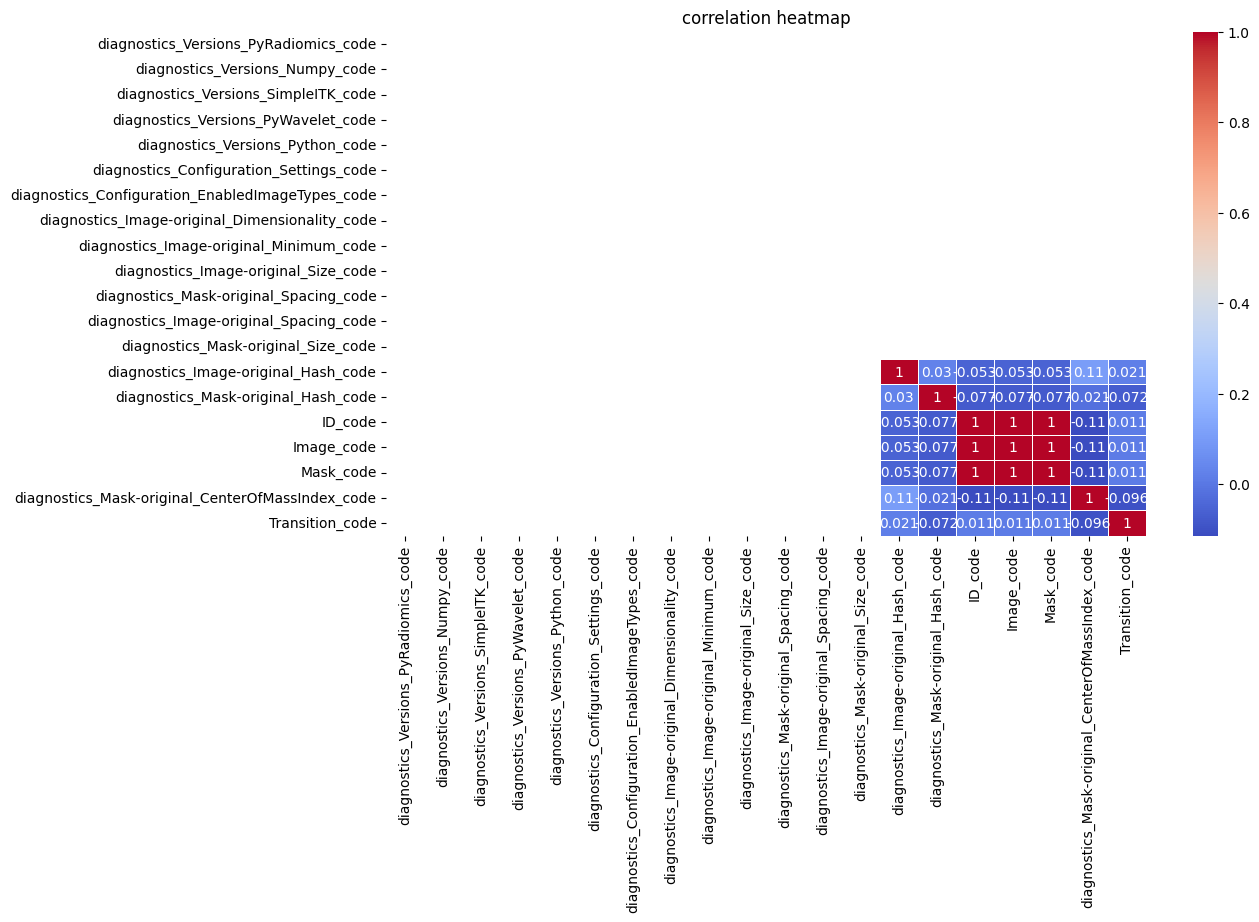

In [28]:
unnecessary_df = pd.DataFrame()
for col in unnecessary_columns+["Transition"]:
    le_make = LabelEncoder()
    unnecessary_df[f"{col}_code"] = le_make.fit_transform(train_df[col])

show_heatmap(unnecessary_df)

## Correlations

In [29]:
def top_correlations(df, target="Transition_code",starts_with=None,number=10,ascending=False):
    if starts_with == None:
        corr_columns = df.select_dtypes(include=["int64","float64"]).columns
    else:
        corr_columns = df.columns[df.columns.str.startswith(starts_with)]

    corr_matrix = df[corr_columns].corrwith(df[target])

    top_features = corr_matrix.sort_values(ascending=ascending).head(number).index.tolist()
    top_features.append(target)
    top_features = pd.Index(top_features)
    
    return top_features

C:\Users\carlo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\carlo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


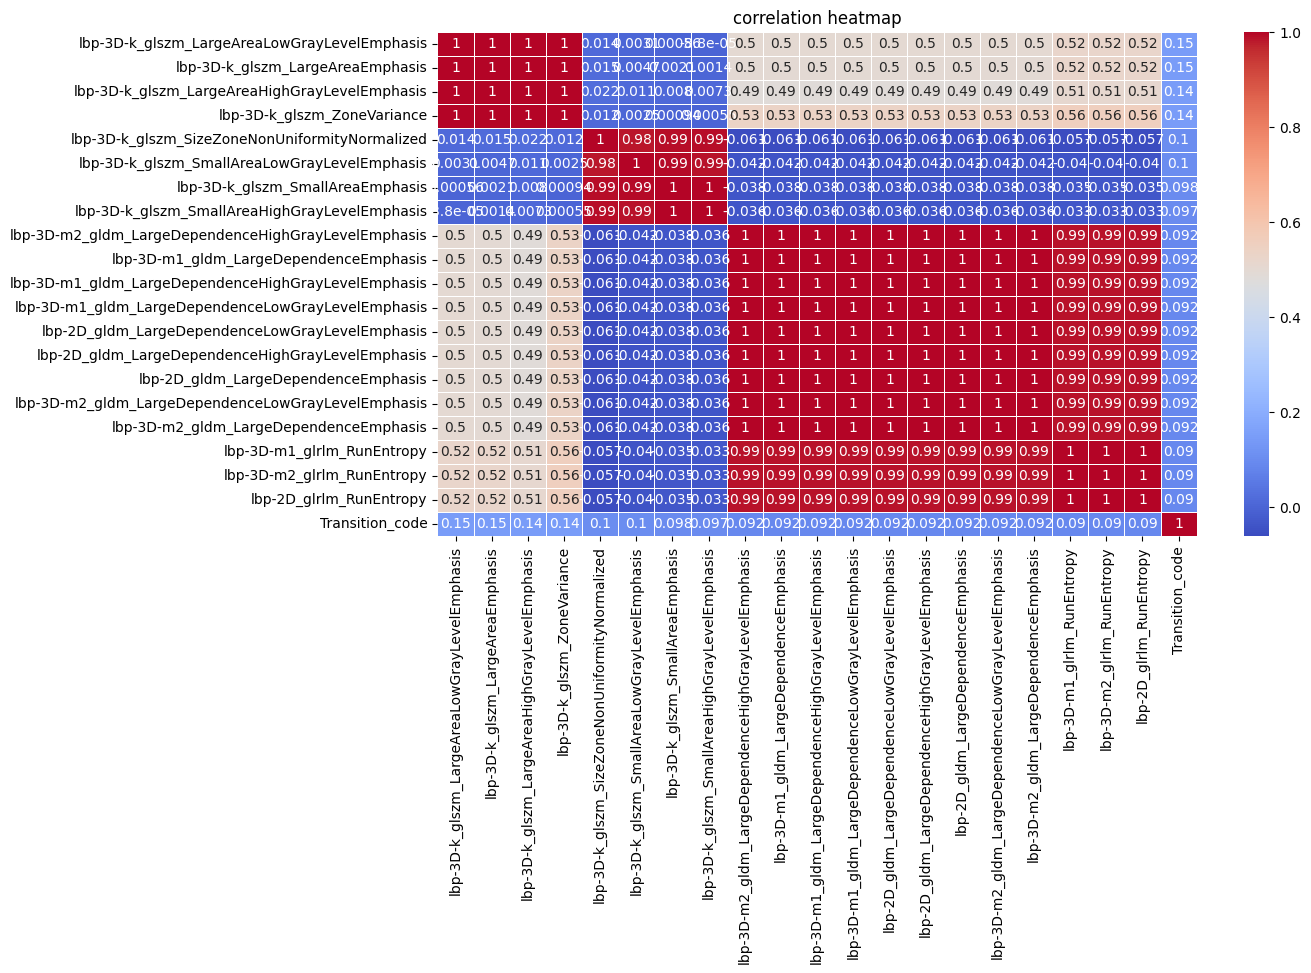

In [30]:
rad_corr = top_correlations(train_df,starts_with="lbp",number=20)
show_heatmap(train_df[rad_corr])

# Save & Load Data

In [31]:
uni_path = "../DataSaver/"

def save_stuff(data,path):
    file_path = os.path.join(uni_path, path)
    
    with open(file_path,"wb") as file:
        pickle.dump(data,file)

def load_stuff(path):
    file_path = os.path.join(uni_path,path)

    with open(file_path,"rb") as file:
        data = pickle.load(file)

    return data

# Data Processing

## Drop Unnecessary Columns

In [32]:
control_df = control_df.drop(columns=unnecessary_columns,axis=1,errors="ignore")
train_df = train_df.drop(columns=unnecessary_columns,axis=1,errors="ignore")
test_df = test_df.drop(columns=unnecessary_columns,axis=1,errors="ignore")

## Nunique Columns

In [33]:
nunique_columns = train_df.columns[train_df.nunique() == 1].tolist()
train_df = train_df.drop(columns=nunique_columns, errors="ignore")
test_df = test_df.drop(columns=nunique_columns, errors="ignore")
control_df = control_df.drop(columns=nunique_columns, errors="ignore")

## Non Numerical Columns

In [34]:
# Separar a coluna de BoundingBox em várias colunas
train_df[['x_min', 'y_min', 'largura', 'altura', 'profundidade', 'extra']] = train_df['diagnostics_Mask-original_BoundingBox'].str.strip('()').str.split(',', expand=True).astype(float)

# Separar a coluna de CenterOfMassIndex em várias colunas
train_df[['x_center', 'y_center', 'z_center']] = train_df['diagnostics_Mask-original_CenterOfMass'].str.strip('()').str.split(',', expand=True).astype(float)

In [35]:
# Separar a coluna de BoundingBox em várias colunas
test_df[['x_min', 'y_min', 'largura', 'altura', 'profundidade', 'extra']] = test_df['diagnostics_Mask-original_BoundingBox'].str.strip('()').str.split(',', expand=True).astype(float)

# Separar a coluna de CenterOfMassIndex em várias colunas
test_df[['x_center', 'y_center', 'z_center']] = test_df['diagnostics_Mask-original_CenterOfMass'].str.strip('()').str.split(',', expand=True).astype(float)

In [36]:
# Separar a coluna de BoundingBox em várias colunas
control_df[['x_min', 'y_min', 'largura', 'altura', 'profundidade', 'extra']] = control_df['diagnostics_Mask-original_BoundingBox'].str.strip('()').str.split(',', expand=True).astype(float)

# Separar a coluna de CenterOfMassIndex em várias colunas
control_df[['x_center', 'y_center', 'z_center']] = control_df['diagnostics_Mask-original_CenterOfMass'].str.strip('()').str.split(',', expand=True).astype(float)

In [37]:
train_df = train_df.drop(['diagnostics_Mask-original_BoundingBox', 'diagnostics_Mask-original_CenterOfMass'], axis=1, errors="ignore")
test_df = test_df.drop(['diagnostaics_Mask-original_BoundingBox', 'diagnostics_Mask-original_CenterOfMass'], axis=1, errors="ignore")
control_df = control_df.drop(['diagnostics_Mask-original_BoundingBox', 'diagnostics_Mask-original_CenterOfMass'], axis=1, errors="ignore")

In [38]:
main_exploration(train_df)

(305, 2024)


In [39]:
train_df = train_df.select_dtypes(include=['number'])
control_df = control_df.select_dtypes(include=['number'])
test_df = test_df.select_dtypes(include=['number'])

## Data Scaler

In [40]:
from sklearn.preprocessing import StandardScaler

def data_scaler(df):
    scaler_df = df.drop(columns=["Transition","Transition_code"],errors="ignore")
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(scaler_df),columns=scaler_df.columns)
    return df_scaled


In [41]:
scaled_train_df = data_scaler(train_df)
scaled_control_df = data_scaler(control_df)
scaled_test_df = data_scaler(test_df)

scaled_train_df["Transition_code"] = train_df["Transition_code"].values
scaled_control_df["Transition_code"] = train_df["Transition_code"].values

## Correlation Analisys

In [42]:
corr_df = scaled_train_df.copy()
corr_df.loc[:,"Transition_code"] = train_df["Transition_code"].values
target = "Transition_code"

In [43]:
corr_threshold = 0
def apply_correlation(df,threshold):
    df = df.drop(columns=["Transition"],errors="ignore")
    correlation = df.corr()[target].abs().sort_values(ascending=False)
    important_features = correlation[correlation > threshold].index.tolist()
    
    if target in important_features:
        important_features.remove(target)

    return important_features

In [44]:
important_features = apply_correlation(scaled_train_df, corr_threshold)

In [45]:
corr_train_df = scaled_train_df[important_features]
corr_control_df = scaled_control_df[important_features]
corr_test_df = scaled_test_df[important_features]

In [46]:
corr_train_df["Transition_code"] = train_df["Transition_code"].values
corr_control_df["Transition_code"] = train_df["Transition_code"].values

In [47]:
main_exploration(corr_train_df)
main_exploration(corr_control_df)
main_exploration(corr_test_df)

(305, 2023)
(305, 2023)
(100, 2022)


# Testing Phase

In [48]:
def define_X_y(train_df, test_df = pd.DataFrame()):
    if test_df.empty:
        X = train_df.drop(columns=["Transition_code","Transition"],errors="ignore")
        y = train_df["Transition_code"]

        x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=27)

        return x_train, x_test, y_train, y_test

    else:
        x_train = train_df.drop("Transition_code",axis=1,errors="ignore")
        y_train = train_df["Transition_code"]
        x_test = test_df

        return x_train, x_test, y_train, None

In [49]:
results = {}
x_train, x_test, y_train, y_test = define_X_y(corr_train_df)
main_exploration(x_train)
main_exploration(x_test)

scorer = make_scorer(f1_score, average='macro')

(244, 2022)
(61, 2022)


## Params

In [50]:
stacking_model

NameError: name 'stacking_model' is not defined

In [ ]:
rf_params = rf_grid_model.get_params()
xgb_params = xgb_grid_model.get_params()
gradient_params = gradient_grid_models.get_params()
print(gradient_params)

In [285]:
param_grid_rf = {
    'n_estimators': [90, 100, 110],
    'max_depth': [5, 6, 7],
    'min_samples_split': [1, 2, 3],
    'min_samples_leaf': [4, 5, 6],
    'class_weight': ['balanced', 'balanced_subsample'],
    'max_features': ['sqrt', 'log2', None]
}

param_grid_xgb = {
    'n_estimators': [140, 150, 160],
    'max_depth': [9, 10, 11],
    'learning_rate': [0.175, 0.2, 0.225],
    'subsample': [0.9, 1.0, 1.1],
    'objective': ['multi:softmax']
}

param_grid_gb = {
    'n_estimators': [225, 150, 250, 375],
    'max_depth': [5, 7, 10],
    'learning_rate': [0.05, 0.1, 0.15],
    'subsample': [0.5, 0.75, 1.0]
}

param_baye_rf = {
    'n_estimators': (20, 400),
    'max_depth': (5, 40),
    'min_samples_split': (2, 8),
    'min_samples_leaf': (1, 6),
    'bootstrap': (0, 1),
    'class_weight': (0, 1),
}

param_baye_xgb = {
    'learning_rate': (0.01, 0.2),
    'n_estimators': (20, 400),
    'max_depth': (5, 20),
    'subsample': (0.4, 1.0),
    'colsample_bytree': (0.3, 0.8),
    'min_child_weight': (1, 10),
}

param_baye_gb = {
    'learning_rate': (0.01, 0.2),
    'n_estimators': (20, 400),
    'max_depth': (5, 20),
    'subsample': (0.4, 1.0),
    'min_samples_split': (2, 8),
    'min_samples_leaf': (1, 6),
}

param_baye_cat = {
    'learning_rate': (0.01, 0.3),       
    'iterations': (20, 400),         
    'depth': (4, 15),                  
    'l2_leaf_reg': (1, 10),              
    'border_count': (32, 255)
}

param_baye_light = {
    'learning_rate': (0.01, 0.3),       # Taxa de aprendizado: valores baixos evitam overfitting
    'num_leaves': (20, 150),            # Número de folhas: valores maiores aumentam a complexidade
    'max_depth': (3, 15),               # Profundidade máxima da árvore
    'min_data_in_leaf': (10, 100),      # Mínimo de amostras por folha
    'bagging_fraction': (0.5, 1.0)      # Fracionamento do bagging para evitar overfitting
}

## Models

### RandomForest

In [256]:
# Basic Model
def random_forest_model(x_train,y_train):
    model = RandomForestClassifier(random_state=27)
    model.fit(x_train,y_train)
    
    return model

# Grid Model
def random_forest_grid_model(x_train,y_train, param_grid_rf=param_grid_rf):
    model = RandomForestClassifier(random_state=27)
    
    grid_search_rf = GridSearchCV(model, param_grid_rf, cv=3, scoring=scorer, n_jobs=-1, verbose=1)
    grid_search_rf.fit(x_train,y_train)
    print(grid_search_rf.best_params_)

    return grid_search_rf.best_estimator_

#Bayes Model
def objective_random_forest(n_estimators, max_depth, min_samples_split, min_samples_leaf,bootstrap,class_weight):
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    
    params = {
        'n_estimators': int(n_estimators),
        'max_depth': int(max_depth),
        'min_samples_split': int(min_samples_split),
        'min_samples_leaf': int(min_samples_leaf),
        'bootstrap': bool(round(bootstrap)),
        'class_weight': None if round(class_weight) == 0 else 'balanced',
        'random_state': 27
    }
    
    model = RandomForestClassifier(**params)
    score = cross_val_score(model, x_train, y_train, cv=cv, scoring=scorer).mean()
    return score

def random_forest_baye_model(x_train,y_train, param_baye=param_baye_rf):
    rf_bo = BayesianOptimization(
        f=objective_random_forest,
        pbounds=param_baye,
        random_state=27,
    )
    
    rf_bo.maximize(init_points=5, n_iter=145)

    best_params = rf_bo.max['params']
    bootstrap = bool(round(best_params["bootstrap"]))
    best_params_updated = {
        'n_estimators': int(best_params['n_estimators']),
        'max_depth': int(best_params['max_depth']),
        'min_samples_split': int(best_params['min_samples_split']),
        'min_samples_leaf': int(best_params['min_samples_leaf']),
        'bootstrap': bootstrap,
        'class_weight': None if round(best_params['class_weight']) == 0 else 'balanced',
        'random_state': 27
    }

    print(best_params_updated)

    model = RandomForestClassifier(**best_params_updated)
    model.fit(x_train,y_train)

    rf_results = pd.DataFrame(rf_bo.res)
    rf_results.sort_values(by="target",ascending=False,inplace=True)

    return model, rf_results, rf_bo.max

### XGBoost

In [263]:
# Basic Model
def xgboost_model(x_train,y_train):
    model = XGBClassifier(random_state=27)
    model.fit(x_train,y_train)

    return model

# Grid Model
def xgboost_grid_model(x_train,y_train, param_grid_xgb=param_grid_xgb):
    model = XGBClassifier(random_state=27)
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    grid_search_xgb = GridSearchCV(model, param_grid_xgb, cv=cv, scoring=scorer, n_jobs=-1, verbose=1)
    grid_search_xgb.fit(x_train,y_train)
    print(grid_search_xgb.best_params_)
    

    return grid_search_xgb.best_estimator_

# Baye Model
def objective_xgboost(learning_rate, n_estimators, max_depth, subsample, colsample_bytree,min_child_weight):
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    
    params = {
        'learning_rate': learning_rate,
        'n_estimators': int(n_estimators),
        'max_depth': int(max_depth),
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'min_child_weight': min_child_weight,
        'random_state': 27
    }
    
    model = XGBClassifier(**params)
    score = cross_val_score(model, x_train, y_train, cv=cv, scoring=scorer).mean()
    return score
    
def xgboost_baye_model(x_train,y_train, param_baye=param_baye_xgb):
    xgb_bo = BayesianOptimization(
    f=objective_xgboost,
    pbounds=param_baye,
    random_state=27,
    )
    
    xgb_bo.maximize(init_points=5, n_iter=100)

    best_params = xgb_bo.max['params']
    best_params_updated = {
        'learning_rate': best_params['learning_rate'],
        'n_estimators': int(best_params['n_estimators']),
        'max_depth': int(best_params['max_depth']), 
        'subsample': best_params['subsample'],
        'colsample_bytree': best_params['colsample_bytree'],
        'min_child_weight': best_params['min_child_weight'],
        'random_state': 27
    }

    print(best_params_updated)
    
    model = XGBClassifier(**best_params_updated)
    model.fit(x_train,y_train)

    xgb_results = pd.DataFrame(xgb_bo.res)
    xgb_results.sort_values(by="target",ascending=False,inplace=True)

    return model, xgb_results, xgb_bo.max

### GradientBoost

In [258]:
# Basic Model
def gradient_boost_model(x_train, y_train):
    model = GradientBoostingClassifier(random_state=27)
    model.fit(x_train,y_train)
    
    return model

# Grid Model
def gradient_grid_model(x_train,y_train, param_grid_gb=param_grid_gb):
    model = GradientBoostingClassifier(random_state=27)
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    grid_search_gb = GridSearchCV(model, param_grid_gb, cv=cv, scoring=scorer, n_jobs=-1, verbose=1)
    grid_search_gb.fit(x_train,y_train)
    print(grid_search_gb.best_params_)

    return grid_search_gb.best_estimator_


# Baye Model
def objective_gradient_boost(learning_rate, n_estimators, max_depth, subsample,min_samples_split,min_samples_leaf):
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    
    params = {
        'learning_rate': learning_rate,
        'n_estimators': int(n_estimators),
        'max_depth': int(max_depth),
        'subsample': subsample,
        'min_samples_split': int(min_samples_split),
        'min_samples_leaf': int(min_samples_leaf),
        'random_state': 27
    }
    
    model = GradientBoostingClassifier(**params)
    score = cross_val_score(model, x_train, y_train, cv=cv, scoring=scorer).mean()
    return score


def gradient_baye_model(x_train,y_train, param_baye=param_baye_gb):
    gb_bo = BayesianOptimization(
        f=objective_gradient_boost,
        pbounds=param_baye,
        random_state=27,
    )
    
    gb_bo.maximize(init_points=5, n_iter=70)

    best_params = gb_bo.max['params']
    best_params_updated = {
        'learning_rate': best_params['learning_rate'],
        'n_estimators': int(best_params['n_estimators']),
        'max_depth': int(best_params['max_depth']),  
        'subsample': best_params['subsample'],
        'min_samples_split': int(best_params['min_samples_split']), 
        'min_samples_leaf': int(best_params['min_samples_leaf']), 
        'random_state': 27 
    }

    print(best_params_updated)
    
    model = GradientBoostingClassifier(**best_params_updated)
    model.fit(x_train,y_train)

    gb_results = pd.DataFrame(gb_bo.res)
    gb_results.sort_values(by="target",ascending=False,inplace=True)

    return model, gb_results, gb_bo.max

## LightGBM

In [264]:
# Basic Model
def light_boost_model(x_train,y_train):
    model =  lgb.LGBMClassifier(verbose=-1)
    model.fit(x_train,y_train)

    return model

# Bayes Model
def objective_light_boost(learning_rate, num_leaves, max_depth, min_data_in_leaf, bagging_fraction):
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    
    params = {
        'learning_rate': learning_rate,
        'num_leaves': int(num_leaves),
        'max_depth': int(max_depth),
        'min_data_in_leaf': int(min_data_in_leaf),
        'bagging_fraction': bagging_fraction,
        'boosting_type': 'gbdt',
        'objective': 'multiclass', 
        'n_jobs': -1,
        'random_state': 27,
        'verbose': -1
    }
    
    model = lgb.LGBMClassifier(**params)
    score = cross_val_score(model, x_train, y_train, cv=cv, scoring=scorer).mean()
    return score


def light_baye_model(x_train, y_train, param_baye=param_baye_light):
    light_bo = BayesianOptimization(
        f=objective_light_boost,
        pbounds=param_baye,
        random_state=27,
    )
    
    light_bo.maximize(init_points=5, n_iter=100)

    best_params = light_bo.max['params']
    best_params_updated = {
        'learning_rate': best_params['learning_rate'],
        'num_leaves': int(best_params['num_leaves']),
        'max_depth': int(best_params['max_depth']),
        'min_data_in_leaf': int(best_params['min_data_in_leaf']),
        'bagging_fraction': best_params['bagging_fraction'],
        'boosting_type': 'gbdt',
        'objective': 'multiclass',
        'n_jobs': -1,
        'random_state': 27,
        'verbose': -1
    }

    print(best_params_updated)
    
    model = lgb.LGBMClassifier(**best_params_updated)
    model.fit(x_train, y_train)

    light_results = pd.DataFrame(light_bo.res)
    light_results.sort_values(by="target", ascending=False, inplace=True)

    return model, light_results, light_bo.max

## CatBoosting

In [260]:
# Basic Model
def cat_boost_model(x_train,y_train):
    model = CatBoostClassifier(verbose=False, task_type="GPU")
    model.fit(x_train,y_train)

    return model

# Bayes Model
def objective_cat_boost(learning_rate, iterations, depth, l2_leaf_reg, border_count):
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    
    params = {
        'learning_rate': learning_rate,
        'iterations': int(iterations),
        'depth': int(depth),
        'l2_leaf_reg': l2_leaf_reg,
        'border_count': int(border_count),
        'task_type': 'GPU',
        'random_seed': 27,
        'verbose': 0
    }
    
    model = CatBoostClassifier(**params)
    score = cross_val_score(model, x_train, y_train, cv=cv, scoring=scorer).mean()
    return score


def cat_baye_model(x_train, y_train, param_baye=param_baye_cat):
    cat_bo = BayesianOptimization(
        f=objective_cat_boost,
        pbounds=param_baye,
        random_state=27,
    )
    
    cat_bo.maximize(init_points=5, n_iter=20)


    best_params = cat_bo.max['params']
    best_params_updated = {
        'learning_rate': best_params['learning_rate'],
        'iterations': int(best_params['iterations']),
        'depth': int(best_params['depth']),
        'l2_leaf_reg': best_params['l2_leaf_reg'],
        'border_count': int(best_params['border_count']),
        'task_type': 'GPU',
        'random_seed': 27,
        'verbose': 0
    }

    print(best_params_updated)
    

    model = CatBoostClassifier(**best_params_updated)
    model.fit(x_train, y_train)


    cat_results = pd.DataFrame(cat_bo.res)
    cat_results.sort_values(by="target", ascending=False, inplace=True)

    return model, cat_results, cat_bo.max

### Logistic Regression L2

In [119]:
def log_reg_model(x_train,y_train):
    model = LogisticRegression(penalty='l2', C=1.0, solver='liblinear',random_state=27)
    model.fit(x_train,y_train)
    
    return model

## Voting Ensemble

In [120]:
def voting_ensemble(x_train,y_train,estimators):
    model = VotingClassifier(estimators=estimators, voting="hard")
    model.fit(x_train,y_train)
    
    return model

## Stacking Ensemble

In [121]:
def stacking_ensemble(x_train,y_train,estimators):
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(random_state=27), cv=cv, n_jobs=-1)
    model.fit(x_train,y_train)
    
    return model

## Models Applier

In [142]:
def apply_basic_models(x_train,y_train,x_test,y_test, title="Models Macro F1 Comparison", rf=1, xgb=1, gradient=0, cat=0, log=0, light=1):
        
    if rf:
        rf_model = random_forest_model(x_train,y_train)
        results["RandomForest"] = [rf_model,None]
    else:
        rf_model = None

    if xgb:
        xgb_model = xgboost_model(x_train,y_train)
        results["XGBoost"] = [xgb_model,None]
    else:
        xgb_model = None
        
    if gradient:
        gradient_model = gradient_boost_model(x_train,y_train)
        results["GradientBoost"] = [gradient_model,None]
    else:
        gradient_model = None
        
    if cat:
        cat_model = cat_boost_model(x_train,y_train)
        results["CatBoost"] = [cat_model,None]
    else:
        cat_model = None
        
    if log:
        log_model = log_reg_model(x_train,y_train)
        results["Logistic"] = [log_model,None]
    else:
        log_model = None      

    if light:
        light_model = light_boost_model(x_train,y_train)
        results["LightGBM"] = [light_model,None]
    else:
        light_model = None   

    if len(x_train) != 305:
        models_comparison(results,title,x_test=x_test,y_test=y_test)

    return rf_model, xgb_model, gradient_model, cat_model, log_model, light_model

## Models Comparison

In [130]:
def models_comparison(results,title,x_test=x_test,y_test=y_test):
    for result in results:
        if results[result][1] == None:
            preds = results[result][0].predict(x_test)
            results[result][1] = f1_score(y_test, preds, average="macro")
        print(f"F1 Macro Score em {result}: {results[result][1]}")
    
    models_score = plt.figure(figsize=(6,3))

    mod = list(results.keys())
    f1 = list([score[1] for score in results.values()])
    
    plt.bar(mod,f1, color = "lightblue", width = 0.5)
    
    plt.xlabel("Model")
    plt.ylabel("Macro F1")
    plt.xticks(rotation=15)
    plt.title(title)
    plt.show()

## Models Tester

F1 Macro Score em RandomForest: 0.28738758825715344
F1 Macro Score em XGBoost: 0.3699461697722567
F1 Macro Score em Logistic: 0.2855373428268444
F1 Macro Score em LightGBM: 0.3362931642001409
F1 Macro Score em StackingBasic: 0.36843800322061193


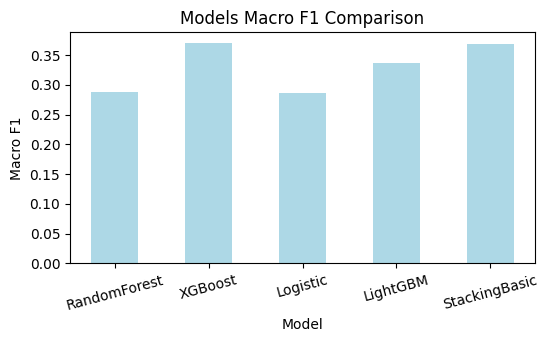

In [143]:
rf_model,xgb_model,gradient_model,cat_model, log_model,light_model = apply_basic_models(x_train,y_train,x_test,y_test)

## Feature Importance Analysis

### Permutation Importance

In [74]:
#print("rf...")
#pi_rf_result = permutation_importance(rf_model,x_test,y_test,n_repeats=10,random_state=27,n_jobs=-1)
#print("xgb...")
#pi_xgb_result = permutation_importance(xgb_model,x_test,y_test,n_repeats=10,random_state=27,n_jobs=-1)
#print("gradient...")
#pi_gradient_result = permutation_importance(gradient_model,x_test,y_test,n_repeats=10,random_state=27,n_jobs=-1)
#print("catboost...")
#pi_cat_result = permutation_importance(cat_model, x_test, y_test, n_repeats=5, random_state=27)
#print("light...")
#pi_light_result = permutation_importance(light_model, x_test, y_test, n_repeats=5, random_state=27)

#pi_rf_result = load_stuff("Permutations/pi_rf_result.pkl")
pi_xgb_result = load_stuff("Permutations/pi_xgb_result.pkl")
#pi_gradient_result = load_stuff("Permutations/pi_gradient_result.pkl")
#pi_cat_result = load_stuff("Permutations/pi_cat_result.pkl")
pi_light_result = load_stuff("Permutations/pi_light_result.pkl")

In [ ]:
x_train, x_test, y_train, y_test = define_X_y(corr_train_df)
main_exploration(x_train)
main_exploration(x_test)

In [ ]:
def show_negative_perm_importance(result, x_test,equal=False):
    negative_importances = pd.Series(result.importances_mean, index=x_test.columns)
    if equal == False:
        negative_importances = negative_importances[negative_importances < 0].sort_values()
    else: 
        negative_importances = negative_importances[negative_importances <= 0].sort_values()
    
    if not negative_importances.empty and len(negative_importances) < 500:
        fig, ax = plt.subplots(figsize=(10, 6))
        negative_importances.plot.bar(ax=ax)
        ax.set_title("Negative Permutation Importance")
        ax.set_ylabel("Mean Accuracy Increase")
        plt.show()
    else:
        print("Não é possível fazer plot!")

    return negative_importances.index.tolist()

def show_positive_perm_importance(result, x_test):
    positive_importances = pd.Series(result.importances_mean, index=x_test.columns)
    positive_importances = positive_importances[positive_importances > 0].sort_values()
    
    if not positive_importances.empty and len(positive_importances) < 500:
        fig, ax = plt.subplots(figsize=(10, 6))
        positive_importances.plot.bar(ax=ax)
        ax.set_title("Positive Permutation Importance")
        ax.set_ylabel("Mean Accuracy Increase")
        plt.show()
    else:
        print("Não é possível fazer plot!")

    return positive_importances.index.tolist()

### Remove Negative Importances

In [ ]:
negative_columns_rf = show_negative_perm_importance(pi_rf_result, x_test)
print(len(negative_columns_rf))

In [ ]:
negative_columns_xgb = show_negative_perm_importance(pi_xgb_result, x_test)
print(len(negative_columns_xgb))

In [ ]:
negative_columns_gradient = show_negative_perm_importance(pi_gradient_result, x_test)
print(len(negative_columns_gradient))

In [ ]:
negative_columns = negative_columns_gradient + negative_columns_xgb + negative_columns_rf
negative_columns = list(dict.fromkeys(negative_columns))
print(len(negative_columns))

### Remove Null Importances

In [ ]:
x_train, x_test, y_train, y_test = define_X_y(corr_train_df)
main_exploration(x_train)
main_exploration(x_test)

In [ ]:
null_columns_rf = show_negative_perm_importance(pi_rf_result, x_test,equal=True)
print(len(null_columns_rf))

In [ ]:
null_columns_xgb = show_negative_perm_importance(pi_xgb_result, x_test,equal=True)
positive_columns_xgb = show_positive_perm_importance(pi_xgb_result, x_test)
print(len(null_columns_xgb))
print(len(positive_columns_xgb))

In [ ]:
null_columns_gradient = show_negative_perm_importance(pi_gradient_result, x_test,equal=True)
print(len(null_columns_gradient))

In [ ]:
null_columns = set(null_columns_rf) & set(null_columns_xgb) & set (null_columns_gradient) 
print(len(null_columns))

## SHAP Analysis

In [75]:
X_shap = corr_train_df.drop("Transition_code", axis=1)  # Features
y_shap = corr_train_df["Transition_code"]

In [ ]:
def get_shap_mean_values(shap_values, X, threshold=0):
    # Verifica se shap_values é um objeto shap.Explanation ou um ndarray
    if hasattr(shap_values, 'values'):
        shap_array = shap_values.values
    else:
        shap_array = shap_values  # É um ndarray

    # Calcula a média dos valores absolutos dos SHAP values
    feature_shap = np.abs(shap_array).mean(axis=(0, 2))

    # Cria o DataFrame com as importâncias médias dos SHAP values
    feature_shap_importance_df = pd.DataFrame({
        "feature": X.columns,
        "importance": feature_shap
    }).sort_values(by="importance", ascending=False)

    # Filtra as features com importância menor ou igual ao threshold
    zero_shap_importance_features_dic = feature_shap_importance_df[
        feature_shap_importance_df["importance"] <= threshold
    ]

    return zero_shap_importance_features_dic

In [79]:
shap_values_xgb = load_stuff("SHAP_Values/shap_values_xgb.pkl")
#shap_values_rf = load_stuff("SHAP_Values/shap_values_rf.pkl")
#shap_values_cat = load_stuff("SHAP_Values/shap_values_cat.pkl")
shap_values_light = load_stuff("SHAP_Values/shap_values_light.pkl")

### Global

In [ ]:
#X_shap_pool = Pool(X_shap)
#explainer = shap.TreeExplainer(cat_model)
#shap_values_cat = explainer.shap_values(X_shap_pool)

In [ ]:
#explainer = shap.Explainer(xgb_model,X_shap)
#shap_values_xgb = explainer(X_shap)

In [78]:
#explainer = shap.Explainer(light_model,X_shap)
#shap_values_light = explainer(X_shap)

In [ ]:
#explainer = shap.Explainer(rf_model,X_shap)
#shap_values_rf = explainer(X_shap,check_additivity=False)

In [ ]:
shap_importances_rf = get_shap_mean_values(shap_values_rf,X_shap,0.0)
print(len(shap_importances_rf))

In [ ]:
shap_importances_xgb = get_shap_mean_values(shap_values_xgb,X_shap,0.01)
print(len(shap_importances_xgb))

In [ ]:
shap_importances_cat = get_shap_mean_values(shap_values_cat,X_shap,0.00)
print(len(shap_importances_cat))

In [ ]:
show_histogram(shap_values_xgb)

In [ ]:
print(len(set(shap_columns_rf) & set(shap_columns_rf) & set(shap_columns_gradient)))

In [ ]:
n_features = shap_values.shape[1]
n_features_per_plot = 10

In [ ]:
for i in range(0, n_features, n_features_per_plot):
    selected_shap_values = shap_values[:, i:i + n_features_per_plot, 1]
    
    shap.plots.heatmap(selected_shap_values)
    
    plt.show()


In [ ]:
for i in range(0, n_features, n_features_per_plot):
    selected_shap_values = shap_values[:, i:i + n_features_per_plot, 1]
    
    shap.summary_plot(selected_shap_values, feature_names=positive_columns_xgb[i:i + n_features_per_plot], show=False)
    
    plt.show()


### Local

In [ ]:
idx = [3, 48, 123, 254, 300, 31, 34, 12, 156, 7, 304, 299, 197, 100, 200, 50]
print(len(idx))

global_shap_values = without_null_imp_train_df.drop("Transition_code",axis=1).mean()

top_positive_features = global_shap_values.nlargest(0)
top_negative_features = global_shap_values.nsmallest(20)


selected_features = pd.concat([top_positive_features, top_negative_features])

fig, ax = plt.subplots(8, 2, figsize=(18, 72))

for i in range(16):
    shap_values = without_null_imp_train_df.iloc[idx[i]]
    
    instance_shap_values = shap_values[selected_features.index]
    
    row, col = divmod(i, 2)
    ax[row, col].bar(instance_shap_values.index, instance_shap_values.values, 
                     color=['#1f77b4' if v > 0 else '#ff7f0e' for v in instance_shap_values.values])
    ax[row, col].set_title(f'SHAP Values of Instance {idx[i]}')
    ax[row, col].tick_params(axis='x', rotation=90)
    ax[row, col].set_xlabel("Features")
    ax[row, col].set_ylabel("SHAP Value")

plt.tight_layout()
plt.show()


In [ ]:
print(top_negative_features.keys())

## SHAP PermImportance Combined

In [80]:
def combine_shap_perm(X, y, shap_values, perm_importance_values, threshold_mean=0, threshold_std=0, threshold_importance=0):
    # verificação para catboost
    if hasattr(shap_values, 'values'):
        shap_array = shap_values.values
    else:
        shap_array = shap_values  

    # Calcula a média e o desvio padrão dos SHAP values
    feature_shap_mean = shap_array.mean(axis=(0, 2))
    feature_shap_std = shap_array.std(axis=(0, 2))
    

    feature_shap_importance_df = pd.DataFrame({
        "feature": X.columns,
        "mean_importance": feature_shap_mean,
        "std_importance": feature_shap_std
    })
    
    low_importance_features = feature_shap_importance_df[
        (feature_shap_importance_df["mean_importance"] <= threshold_mean) & 
        (feature_shap_importance_df["std_importance"] <= threshold_std)
    ]

    mean_std_df, low_importance_features = feature_shap_importance_df, low_importance_features


    perm_importance_df = pd.DataFrame({
        "feature": X.columns,
        "perm_importance": perm_importance_values.importances_mean
    })
    
    perm_importance_df = perm_importance_df.sort_values(by="perm_importance", ascending=False)


    combined_importance_df = mean_std_df.merge(perm_importance_df, on="feature", how="left")

    combined_importance_df = combined_importance_df.sort_values(by="mean_importance", ascending=False)
    
    discard_features = combined_importance_df[
        (combined_importance_df["mean_importance"] <= threshold_mean) & 
        (combined_importance_df["std_importance"] <= threshold_std) & 
        (combined_importance_df["perm_importance"] <= threshold_importance)
    ]
    
    return discard_features["feature"]


In [246]:
discard_xgb = combine_shap_perm(X_shap,y_shap,shap_values_xgb,pi_xgb_result,threshold_mean=0.03,threshold_std=0.017,threshold_importance=0.03)
discard_light = combine_shap_perm(X_shap,y_shap,shap_values_light,pi_light_result,threshold_mean=0.03,threshold_std=0.02,threshold_importance=0.03)

In [247]:
combined = set(discard_xgb) & set(discard_light)

In [248]:
print(len(discard_xgb))
print(len(discard_light))
print(len(combined))

1777
1766
1631


## Models Tester

In [249]:
shap_train_df = corr_train_df.drop(columns=combined)
shap_train_df.to_csv("../Dataset/new_db.csv",index=False)
shap_control_df = corr_control_df.drop(columns=[])
shap_test_df = corr_test_df.drop(columns=combined)
results = {}
x_train, x_test, y_train, y_test = define_X_y(shap_train_df)
main_exploration(x_train)
main_exploration(x_test)

(244, 391)
(61, 391)


### Basic Models

F1 Macro Score em RandomForest: 0.384030784030784
F1 Macro Score em XGBoost: 0.4358095238095238
F1 Macro Score em LightGBM: 0.3172595520421607


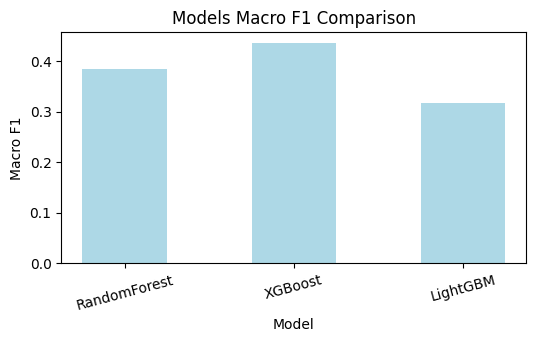

In [250]:
rf_model, xgb_model, gradient_model, cat_model, log_model, light_model = apply_basic_models(x_train,y_train,x_test,y_test)

In [251]:
rf_model = RandomForestClassifier(**rf_model.get_params())
rf_model

RandomForestClassifier(random_state=27)

In [252]:
xgb_model = XGBClassifier(**xgb_model.get_params())
xgb_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [253]:
light_model = lgb.LGBMClassifier(**light_model.get_params())
light_model

LGBMClassifier(verbose=-1)

F1 Macro Score em RandomForest: 0.384030784030784
F1 Macro Score em XGBoost: 0.4358095238095238
F1 Macro Score em LightGBM: 0.3172595520421607
F1 Macro Score em StackingBasic: 0.3722889844718233


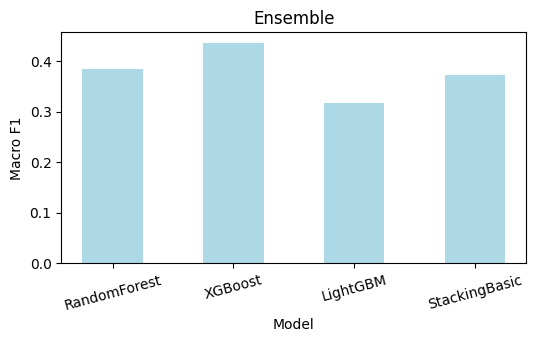

In [254]:
stacking_model = stacking_ensemble(x_train,y_train,[("rf",rf_model),("xgb",xgb_model),("light",light_model)])
results["StackingBasic"] = [stacking_model,None]

models_comparison(results,"Ensemble",x_test=x_test,y_test=y_test)

### BayesOptimizer Tuning

In [261]:
def bayes_visualization(params,bayes_results,best_hyperparameters):
    param_names = list(params.keys())

    cols = 3
    rows = math.ceil(len(param_names)/cols)
    
    fig, axes = plt.subplots(rows,cols,figsize=(4*cols,4*rows))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)

    for i, param in enumerate(param_names):
        if param != "target":
            ax = axes[i//3, i%3]
            ax.plot(bayes_results['params'].apply(lambda x: x[param]),
                bayes_results['target'], 'bo-', lw=1, markersize=4)
            ax.set_title(f'Optimization of {param}')
            ax.set_xlabel(param)
            ax.set_ylabel('F1 Macro Score')
     
            best_value = best_hyperparameters['params'][param]
            ax.plot(best_value, best_hyperparameters['target'], 'yo', markersize=6)
            
    for i in range(len(param_names), 6):
        fig.delaxes(axes.flatten()[i])
 
    plt.show()

|   iter    |  target   | bootstrap | class_... | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------------------
| 1         | 0.3341    | 0.4257    | 0.8146    | 30.74     | 5.34      | 4.3       | 392.2     |
| 2         | 0.3298    | 0.8932    | 0.2097    | 30.96     | 4.316     | 7.321     | 346.0     |
| 3         | 0.3148    | 0.7493    | 0.8701    | 11.54     | 2.628     | 4.238     | 321.6     |
| 4         | 0.3385    | 0.1511    | 0.1699    | 7.841     | 2.526     | 6.7       | 81.9      |
| 5         | 0.3208    | 0.07064   | 0.7011    | 11.33     | 3.995     | 4.492     | 215.2     |
| 6         | 0.3517    | 0.5378    | 0.399     | 7.109     | 1.165     | 6.079     | 82.91     |
| 7         | 0.3702    | 0.883     | 0.6963    | 6.63      | 2.331     | 4.057     | 83.26     |
| 8         | 0.3211    | 0.9004    | 0.4045    | 5.837     | 2.681     | 2.58      | 85.28     |
| 9         | 0.3374

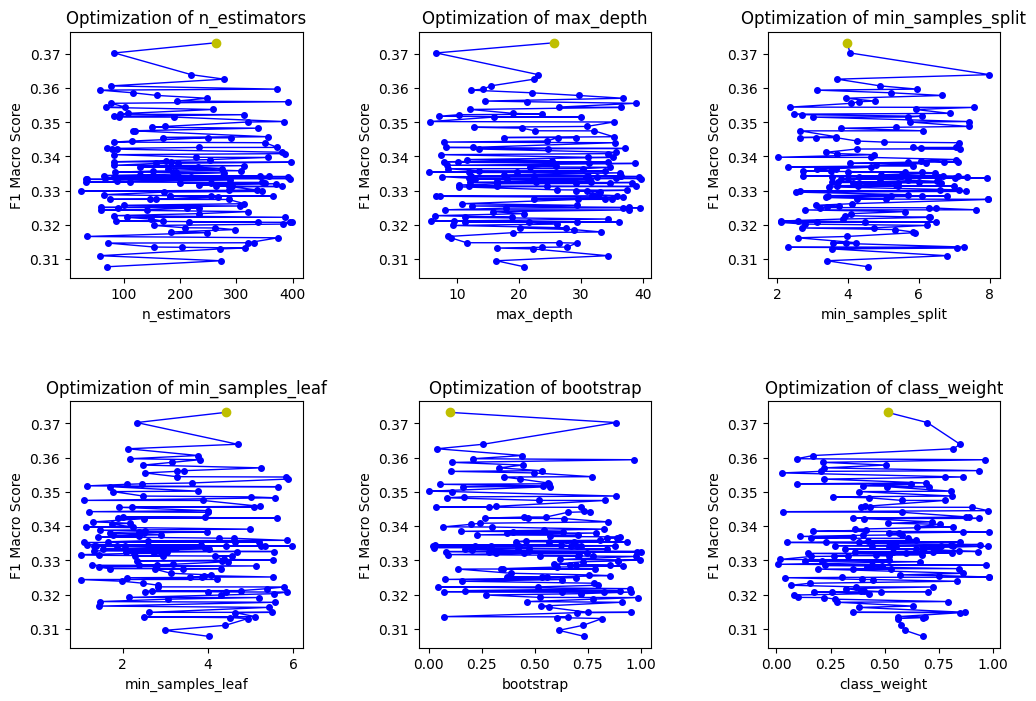

F1 Macro Score em RandomForestBaye: 0.35050397877984085


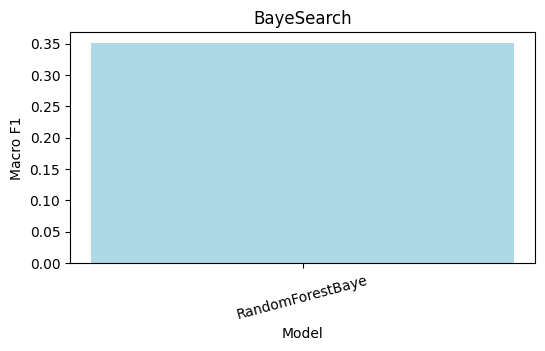

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------
| 1         | 0.3396    | 0.5129    | 0.1648    | 16.03     | 8.812     | 165.7     | 0.9877    |
| 2         | 0.3458    | 0.7466    | 0.04985   | 16.13     | 6.968     | 357.0     | 0.9148    |
| 3         | 0.3812    | 0.6746    | 0.1753    | 7.801     | 3.93      | 161.7     | 0.8762    |
| 4         | 0.3627    | 0.3755    | 0.04229   | 6.218     | 3.747     | 317.7     | 0.4977    |
| 5         | 0.3538    | 0.3353    | 0.1432    | 7.715     | 6.39      | 177.8     | 0.7081    |
| 6         | 0.346     | 0.7747    | 0.1375    | 6.191     | 3.826     | 317.4     | 0.5663    |
| 7         | 0.353     | 0.6676    | 0.09179   | 13.6      | 2.566     | 173.1     | 0.4244    |
| 8         | 0.3667    | 0.5822    | 0.09208   | 7.003     | 2.542     | 325.3     | 0.8652    |
| 9         | 0.3962

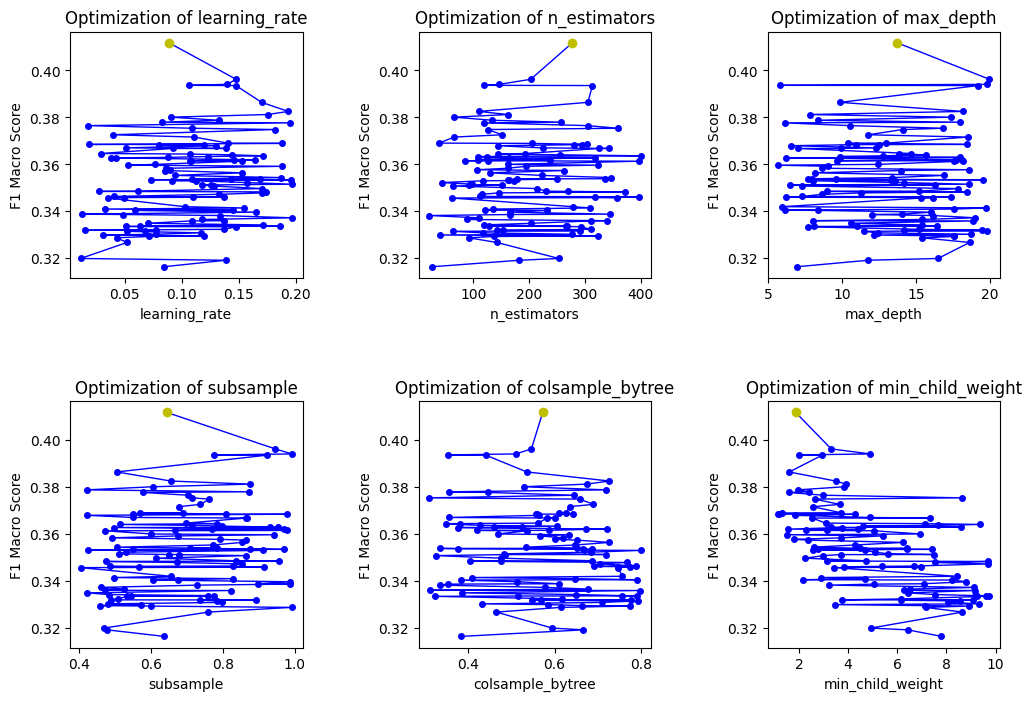

F1 Macro Score em RandomForestBaye: 0.35050397877984085
F1 Macro Score em XGBoostBaye: 0.292731451554981


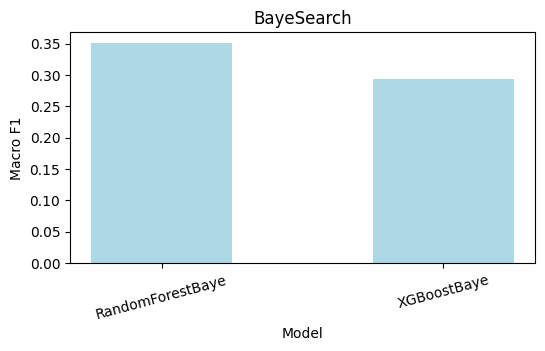

|   iter    |  target   | baggin... | learni... | max_depth | min_da... | num_le... |
-------------------------------------------------------------------------------------
| 1         | 0.0969    | 0.7129    | 0.2462    | 11.82     | 88.12     | 69.84     |
| 2         | 0.3671    | 0.9897    | 0.269     | 5.517     | 76.76     | 106.2     |
| 3         | 0.0969    | 0.9434    | 0.2588    | 11.99     | 88.31     | 44.28     |
| 4         | 0.402     | 0.6628    | 0.1182    | 12.52     | 23.6      | 42.09     |
| 5         | 0.3743    | 0.5406    | 0.0985    | 12.4      | 24.66     | 29.18     |
| 6         | 0.3868    | 0.7412    | 0.2565    | 12.32     | 22.61     | 41.24     |
| 7         | 0.394     | 0.6476    | 0.2654    | 14.55     | 34.93     | 63.49     |
| 8         | 0.3276    | 0.5048    | 0.06251   | 3.009     | 43.74     | 38.78     |
| 9         | 0.3713    | 0.7458    | 0.2571    | 3.387     | 62.61     | 135.6     |
| 10        | 0.387     | 0.9753    | 0.1641    | 4.90

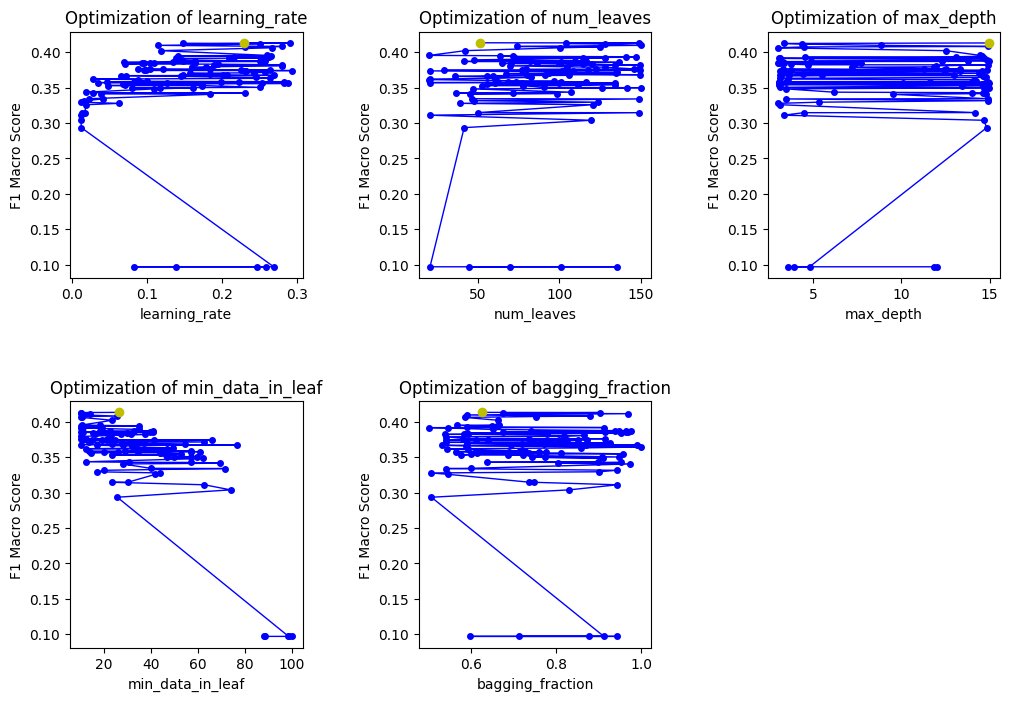

F1 Macro Score em RandomForestBaye: 0.35050397877984085
F1 Macro Score em XGBoostBaye: 0.292731451554981
F1 Macro Score em CatBaye: 0.30588533125557293


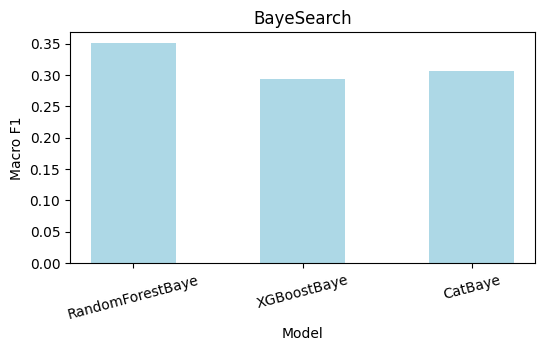

In [265]:
results = {}

rf_baye_model, rf_baye_results, best_params = random_forest_baye_model(x_train,y_train)
results["RandomForestBaye"] = [rf_baye_model,None]
bayes_visualization(param_baye_rf, rf_baye_results, best_params)
models_comparison(results, "BayeSearch",x_test=x_test,y_test=y_test)

xgb_baye_model, xgb_baye_results, best_params = xgboost_baye_model(x_train,y_train)
results["XGBoostBaye"] = [xgb_baye_model,None]
bayes_visualization(param_baye_xgb, xgb_baye_results, best_params)
models_comparison(results, "BayeSearch",x_test=x_test,y_test=y_test)

light_baye_model, light_baye_results, best_params = light_baye_model(x_train,y_train)
results["LightBoost"] = [light_baye_model,None]
bayes_visualization(param_baye_light, light_baye_results, best_params)
models_comparison(results, "BayeSearch",x_test=x_test,y_test=y_test)

### GridSearch Tuning

In [ ]:
results = {}
rf_grid_model = random_forest_grid_model(x_train,y_train)
results["RandomForestGrid"] = [rf_grid_model,None]
models_comparison(results, "GridSearch",x_test=x_test,y_test=y_test)

xgb_grid_model = xgboost_grid_model(x_train,y_train)
results["XGBoostGrid"] = [xgb_grid_model,None]
models_comparison(results, "GridSearch",x_test=x_test,y_test=y_test)

gradient_grid_model = gradient_grid_model(x_train,y_train)
results["GradientGrid"] = [gradient_grid_model,None]

models_comparison(results, "GridSearch",x_test=x_test,y_test=y_test)

In [ ]:
rf_ensemble = RandomForestClassifier(**rf_grid_model.get_params())
xgb_ensemble = XGBClassifier(**xgb_grid_model.get_params())
gb_ensemble = GradientBoostingClassifier(**gradient_grid_models.get_params())

#voting_model = voting_ensemble(x_train,y_train,estimators=[("rf",rf_ensemble),("xgb",xgb_ensemble),("gb",gb_ensemble)],weights=[1,1,1])
stacking_model = stacking_ensemble(x_train,y_train,estimators=[("rf",rf_ensemble),("xgb",xgb_ensemble),("gb",gb_ensemble)])

#results["VotingGrid"] = [voting_model,None]
results["StackingGrid"] = [stacking_model,None]

models_comparison(results,"Grid Ensemble",x_test=x_test,y_test=y_test)

## Ensemble Tester

In [266]:
rf_ensemble = RandomForestClassifier(**rf_baye_model.get_params())
rf_ensemble

RandomForestClassifier(bootstrap=False, class_weight='balanced', max_depth=25,
                       min_samples_leaf=4, min_samples_split=3,
                       n_estimators=263, random_state=27)

In [267]:
xgb_ensemble = XGBClassifier(**xgb_baye_model.get_params())
xgb_ensemble

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5727242884974683, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.0888334979167768,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=13, max_leaves=None,
              min_child_weight=1.8651520832316146, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=277,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [268]:
light_ensemble = lgb.LGBMClassifier(**light_baye_model.get_params())
light_ensemble

LGBMClassifier(bagging_fraction=0.6256447325560861,
               learning_rate=0.22913212490860807, max_depth=14,
               min_data_in_leaf=26, n_jobs=-1, num_leaves=51,
               objective='multiclass', random_state=27, verbose=-1)

F1 Macro Score em RandomForestBaye: 0.35050397877984085
F1 Macro Score em XGBoostBaye: 0.292731451554981
F1 Macro Score em CatBaye: 0.30588533125557293
F1 Macro Score em StackingBaye: 0.3442714218155766


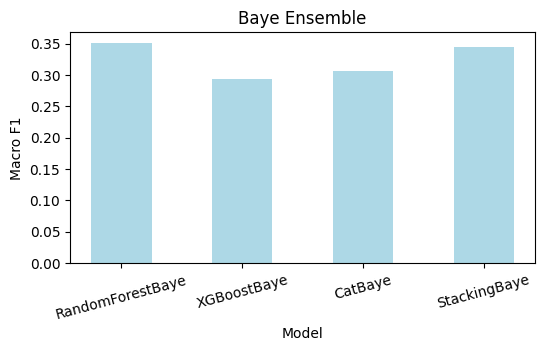

In [269]:
stacking_model = stacking_ensemble(x_train,y_train,estimators=[("rf",rf_ensemble),("xgb",xgb_ensemble),("light",light_ensemble)])

results["StackingBaye"] = [stacking_model,None]

models_comparison(results,"Baye Ensemble",x_test=x_test,y_test=y_test)

# Get Preds

In [276]:
shap_train_df = corr_train_df.drop(columns=combined)
shap_control_df = corr_control_df.drop(columns=combined)
shap_test_df = corr_test_df.drop(columns=combined)
results = {}
x_train, x_test, y_train, y_test = define_X_y(shap_control_df,shap_test_df)
main_exploration(x_train)
main_exploration(x_test)

(305, 391)
(100, 391)


In [277]:
rf_params = rf_ensemble.get_params()
xgb_params = xgb_ensemble.get_params()
light_params = light_ensemble.get_params()

In [278]:
rf_preds_model = RandomForestClassifier(**rf_params)
xgb_preds_model = XGBClassifier(**xgb_params)
light_preds_model = lgb.LGBMClassifier(**light_params)

In [279]:
#voting_model = voting_ensemble(x_train,y_train,estimators=[("rf",rf_grid_model),("xgb",xgb_grid_model),("gb",gradient_grid_models)],weights=[1,1,1])
stacking_model = stacking_ensemble(x_train,y_train,estimators=[("rf",rf_preds_model),("xgb",xgb_preds_model),("light",light_preds_model)])


## Preds to CSV

In [280]:
def preds_to_csv(preds, df=dummy_df):
    if len(preds) == 100:
        y_pred_original = target_decoder(le_make_train, preds)
        
        df["Result"] = y_pred_original
        
        df.to_csv("../Dataset/dummy_submission.csv", index=False)

        print("CSV updated!\n", y_pred_original)
    else:
        print("Invalid input!")


In [281]:
preds_to_csv(stacking_model.predict(x_test))

CSV updated!
 ['CN-CN' 'CN-CN' 'CN-CN' 'CN-CN' 'CN-CN' 'CN-CN' 'AD-AD' 'CN-CN' 'CN-CN'
 'CN-CN' 'CN-CN' 'CN-CN' 'CN-CN' 'CN-CN' 'MCI-MCI' 'CN-CN' 'CN-CN'
 'MCI-MCI' 'CN-CN' 'CN-CN' 'AD-AD' 'CN-CN' 'CN-CN' 'CN-CN' 'AD-AD' 'CN-CN'
 'CN-CN' 'CN-CN' 'CN-CN' 'CN-CN' 'CN-CN' 'CN-CN' 'CN-CN' 'CN-CN' 'CN-CN'
 'CN-CN' 'CN-CN' 'CN-CN' 'CN-CN' 'CN-CN' 'MCI-MCI' 'CN-CN' 'MCI-MCI'
 'CN-CN' 'CN-CN' 'MCI-MCI' 'CN-CN' 'CN-CN' 'CN-CN' 'CN-CN' 'MCI-MCI'
 'CN-CN' 'CN-CN' 'CN-CN' 'CN-CN' 'MCI-MCI' 'CN-CN' 'CN-CN' 'MCI-MCI'
 'CN-CN' 'CN-CN' 'AD-AD' 'CN-CN' 'CN-CN' 'CN-CN' 'CN-CN' 'CN-CN' 'CN-CN'
 'AD-AD' 'CN-CN' 'CN-CN' 'AD-AD' 'CN-CN' 'CN-CN' 'MCI-MCI' 'MCI-MCI'
 'CN-CN' 'CN-CN' 'CN-CN' 'CN-CN' 'CN-CN' 'CN-CN' 'AD-AD' 'CN-CN' 'CN-CN'
 'CN-CN' 'MCI-MCI' 'MCI-MCI' 'CN-CN' 'CN-CN' 'AD-AD' 'CN-CN' 'CN-CN'
 'CN-CN' 'CN-CN' 'CN-CN' 'CN-CN' 'CN-CN' 'CN-CN' 'CN-CN']


In [ ]:
save_stuff(shap_values_xgb,"SHAP_Values/shap_values_xgb.pkl")
save_stuff(shap_values_rf,"SHAP_Values/shap_values_rf.pkl")
save_stuff(shap_values_gradient,"SHAP_Values/shap_values_gradient.pkl")

In [ ]:
stacking_model